# set-up

In [2]:
library(reticulate)

use_python("/storage/joypai/.linuxbrew/bin/python3")

reticulate::py_config()

python:         /storage/joypai/.linuxbrew/bin/python3
libpython:      /storage/joypai/.linuxbrew/Cellar/python/3.7.3/lib/libpython3.7m.so
pythonhome:     /storage/joypai/.linuxbrew/Cellar/python/3.7.3:/storage/joypai/.linuxbrew/Cellar/python/3.7.3
version:        3.7.3 (default, May 16 2019, 10:07:48)  [GCC 5.5.0]
numpy:          /storage/joypai/.linuxbrew/Cellar/python/3.7.3/lib/python3.7/site-packages/numpy
numpy_version:  1.16.4

python versions found: 
 /storage/joypai/.linuxbrew/bin/python3
 /storage/joypai/.linuxbrew/bin/python
 /usr/bin/python

In [3]:
setwd("/storage/joypai/ms_epic/")

library(Seurat)
library(cowplot)
library(magrittr)
library(dplyr)
library(ggsci)

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# integrate datasets (don't need to run again !!)

In [5]:
# create individual seurat object for each sample
all_sample_dirs <- list.files(path=".", pattern="-WTA$", include.dirs = T)

seurat_obj_list <- list()
for (dir in all_sample_dirs) {
  dirname <- unlist(strsplit(dir, '-'))[1]
  print(dirname)
  data <- Read10X(data.dir = paste0(dir,"/outs/filtered_feature_bc_matrix/"))
  
  # Initialize the Seurat object with the raw (non-normalized data)
  seurat_obj <- CreateSeuratObject(counts = data, project = dirname, min.cells = 3, min.features = 200)
  # seurat_obj$sample <- dirname
  seurat_obj[["percent.mt"]] <- PercentageFeatureSet(seurat_obj, pattern = "^MT-")
  
  seurat_obj <- subset(seurat_obj, subset = nFeature_RNA > 200 & percent.mt < 10)
  seurat_obj <- NormalizeData(seurat_obj, verbose = FALSE)
  seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)
  seurat_obj_list[[dirname]] <- seurat_obj
}

In [ ]:
# save(seurat_obj_list, file="seurat_obj_list.RData")

In [ ]:
# remove sample (09102018-WTA) with too few reads
names(seurat_obj_list)
seurat_obj_list['09102018'] <- NULL

In [ ]:
# merge datasets
immune.anchors <- FindIntegrationAnchors(object.list = seurat_obj_list, dims = 1:20)
merged.integrated <- IntegrateData(anchorset = immune.anchors, dims = 1:20)

In [ ]:
# save(immune.anchors, file="immune.anchors.no09102018.RData")
# save(merged.integrated, file="merged.integrated.09102018.RData")

In [4]:
load(file="r_objects/seurat_obj_list.RData")
# load(file="r_objects/immune.anchors.RData")
# load(file="r_objects/merged.integrated.RData")
load(file="r_objects/merged.integrated.processed.RData")

In [6]:
names(seurat_obj_list)

[1] "01092019" "03042019" "08162018" "09102018" "11132018" "6538"    
 [7] "658"      "9020"     "HC11"     "HC12"     "HC13"     "HC14"    
[13] "HC15"

In [7]:
# A list of cell cycle markers, from Tirosh et al, 2015, is loaded with Seurat.  We can
# segregate this list into markers of G2/M phase and markers of S phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes

merged.integrated <- CellCycleScoring(merged.integrated, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)


# clustering based on expression

In [8]:
DefaultAssay(object = merged.integrated) <- "integrated"
merged.integrated <- ScaleData(object = merged.integrated, vars.to.regress = c("S.Score", "G2M.Score"),
                               verbose = FALSE)
merged.integrated <- RunPCA(object = merged.integrated, npcs = 50, verbose = FALSE)

In [9]:
merged.integrated <- RunUMAP(merged.integrated, reduction = "pca", dims = 1:20)
# merged.integrated <- RunTSNE(object = merged.integrated, reduction = "pca", dims = 1:50)

In [10]:
merged.integrated <- FindNeighbors(object = merged.integrated)
merged.integrated <- FindClusters(object = merged.integrated, resolution = 0.2)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 86983
Number of edges: 2598535

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9457
Number of communities: 10
Elapsed time: 84 seconds


In [172]:
merged.integrated@meta.data$group <- ifelse(grepl("^HC",merged.integrated@meta.data$orig.ident), "healthy", "MS")

In [11]:
# save(merged.integrated, file="r_objects/merged.integrated.processed.RData")
# load(file="r_objects/merged.integrated.processed.RData")

In [77]:
mypal = pal_npg("nrc", alpha = 1)(10)

p1 <- DimPlot(object = merged.integrated, reduction = "umap", group.by = "orig.ident")
umapplot_seurat_clusters <- DimPlot(object = merged.integrated, reduction = "umap", 
                                    group.by = "integrated_snn_res.0.2", 
                                    label = TRUE, repel = TRUE, cols=mypal)

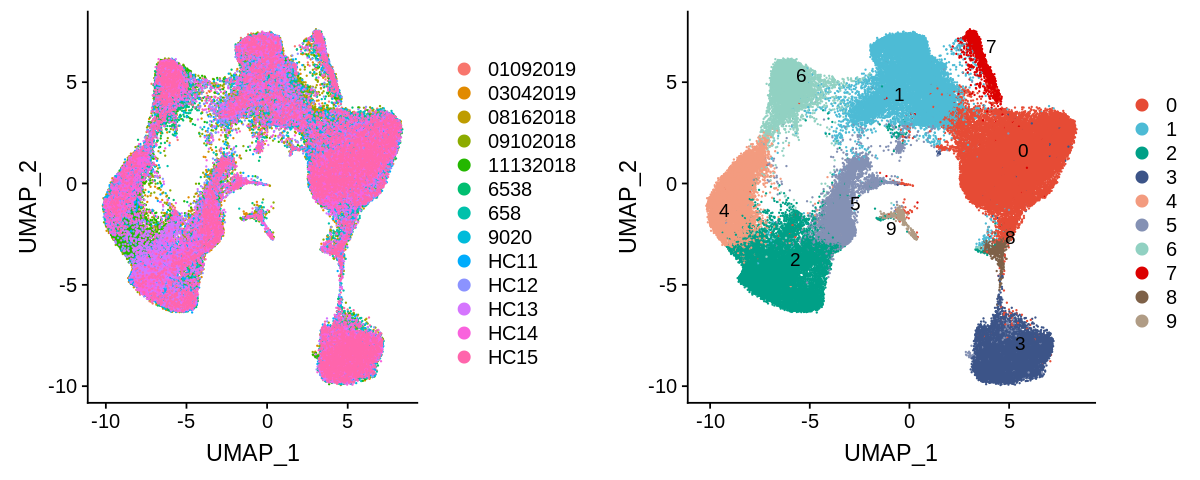

In [114]:
options(repr.plot.width=10, repr.plot.height=4)
plot_grid(p1, umapplot_seurat_clusters)

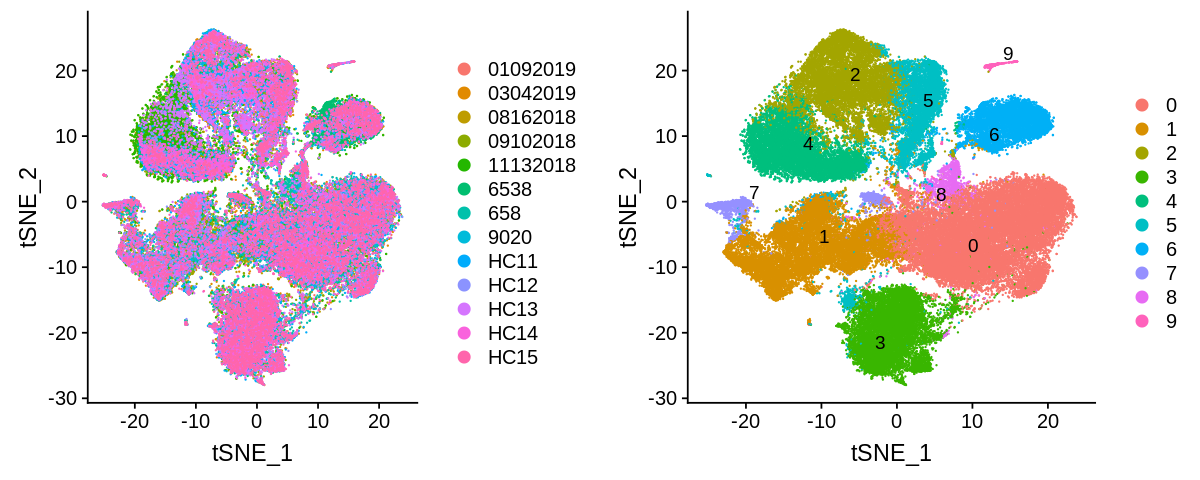

In [87]:
# tSNE output
options(repr.plot.width=10, repr.plot.height=4)
plot_grid(p1, p2)

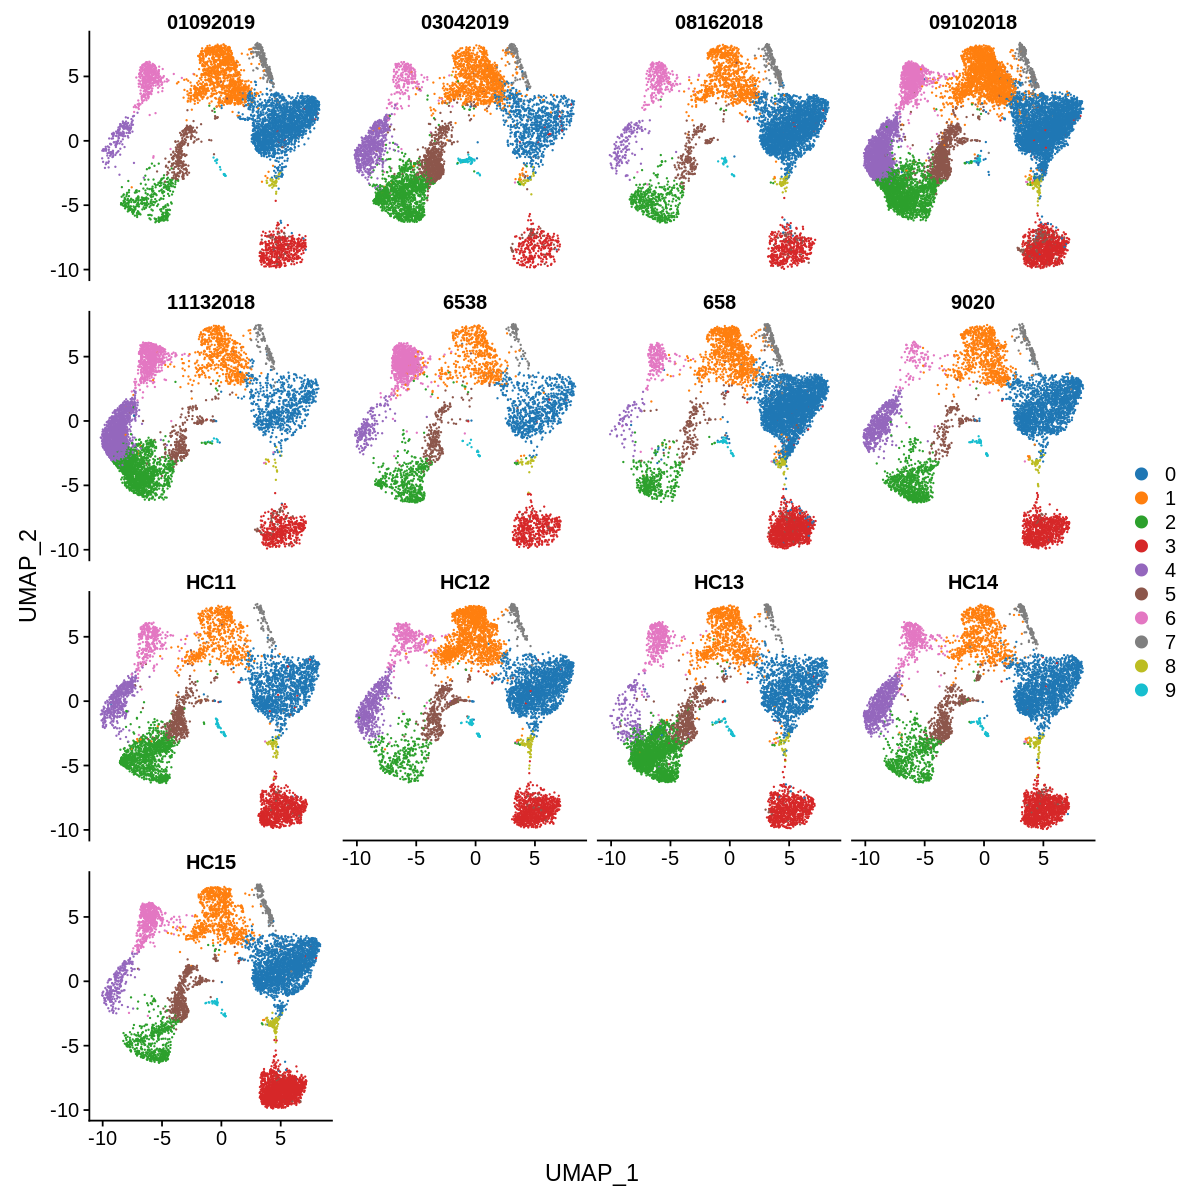

In [14]:
options(repr.plot.width=10, repr.plot.height=10)

mypal = pal_d3("category10", alpha = 1)(10)

DimPlot(merged.integrated, reduction = "umap", split.by = "orig.ident", cols=mypal)

In [70]:
options(repr.plot.width=10, repr.plot.height=10)

mypal = pal_npg("nrc", alpha = 1)(10)

DimPlot(merged.integrated, reduction = "umap", 
        split.by = "orig.ident", group.by = "seurat_clusters", cols=mypal)


In [44]:
class(merged.integrated)
merged.integrated@assays$integrated@data[1:5,1:5]

[1] "Seurat"
attr(,"package")
[1] "Seurat"

,AAACCTGAGACCTAGG_1,AAACCTGAGAGTGAGA_1,AAACCTGAGCACACAG_1,AAACCTGAGGCTAGGT_1,AAACCTGCAGTCACTA_1
TRBV7-2,-0.5372687,-0.429564150,0.44522819,-0.09625656,0.36281077
TRBV10-3,0.0946844,0.016443047,-0.34883109,0.18916077,-0.26235793
TRBV4-1,-0.1399526,-0.076599452,-0.06927037,-0.06266401,-0.32683588
TRBV12-3,-0.3053550,0.270872715,-0.04577351,-0.12638729,-0.04910025
TRBV7-9,0.5720241,0.006149349,-0.34974318,-0.11455723,0.92104091


In [13]:
merged.exp.matrix <- GetAssayData(merged.integrated, slot="scale.data", assay="integrated")

# cluster annotation

## define clusters using SingleR

In [8]:
library(SingleR)
load("r_objects/calderon_ref.RData")

In [48]:
calderon_ref$de.genes$CD8pos_T$Th17_precursors[100:120]

[1] "cdc25c"  "cdh9"    "cdkn2c"  "cdr2l"   "cep55"   "cep72"   "cfap52" 
 [8] "chit1"   "chrna2"  "clec12a" "clec4d"  "clic6"   "cmip"    "cmtm4"  
[15] "cnbd1"   "col20a1" "col4a4"  "col6a2"  "colq"    "copz2"   "cp"

In [128]:
length(merged.integrated$seurat_clusters)
dim(merged.exp.matrix)

[1] 86983

[1]  2000 86983

[1] 10000

In [140]:
set.seed(10)
num_cells_to_sample <- 8000
select_cells <- sample(1:ncol(merged.exp.matrix), num_cells_to_sample)

In [141]:
head(select_cells)

[1] 44142 26684 37133 60287  7406 19609

In [143]:
singler = CreateSinglerObject(merged.exp.matrix[,select_cells], annot = NULL,
                              project.name="merged", min.genes = 0,
                              technology = "10X", species = "Human", citation = "",
                              ref.list = list(hpca, blueprint_encode, calderon_ref), 
                              normalize.gene.length = F, variable.genes = "de",
                              fine.tune = T, do.signatures = F, 
                              clusters = merged.integrated$seurat_clusters[select_cells],
                              do.main.types = T, 
                              reduce.file.size = T, numCores = 40)

[1] "Dimensions of counts data: 2000x8000"
[1] "Annotating data with HPCA..."
[1] "Variable genes method: de"
[1] "Number of DE genes:817"
[1] "Number of cells: 8000"
[1] "Fine-tuning round on top cell types (using 40 CPU cores):"
[1] "Number of DE genes:817"
[1] "Number of clusters: 10"
[1] "Fine-tuning round on top cell types (using 40 CPU cores):"
[1] "Annotating data with HPCA (Main types)..."
[1] "Number of DE genes:653"
[1] "Number of cells: 8000"
[1] "Fine-tuning round on top cell types (using 40 CPU cores):"
[1] "Number of DE genes:653"
[1] "Number of clusters: 10"
[1] "Fine-tuning round on top cell types (using 40 CPU cores):"
[1] "Annotating data with Blueprint_Encode..."
[1] "Variable genes method: de"
[1] "Number of DE genes:890"
[1] "Number of cells: 8000"
[1] "Fine-tuning round on top cell types (using 40 CPU cores):"
[1] "Number of DE genes:890"
[1] "Number of clusters: 10"
[1] "Fine-tuning round on top cell types (using 40 CPU cores):"
[1] "Annotating data with Blueprin

In [171]:
# save(singler, file="r_objects/singler.RData")
load(file="r_objects/singler.RData")

In [32]:
head(singler_cald$singler[[1]]$SingleR.single$labels)

AAACCTGAGACCTAGG_1,Naive_Teffs
AAACCTGAGAGTGAGA_1,Naive_Teffs
AAACCTGAGCACACAG_1,Naive_Teffs
AAACCTGAGGCTAGGT_1,Effector_CD4pos_T
AAACCTGCAGTCACTA_1,Memory_Tregs
AAACCTGCATCGACGC_1,Effector_CD4pos_T


In [ ]:

# singler$seurat = seurat_obj # (optional)
# singler$meta.data$orig.ident = seurat_obj@meta.data$orig.ident # the original identities, if not supplied in 'annot'

# ## if using Seurat v3.0 and over use:
# singler$meta.data$xy = seurat_obj@reductions$tsne@cell.embeddings # the tSNE coordinates
# singler$meta.data$clusters = seurat_obj@active.ident # the Seurat clusters (if 'clusters' not provided)


In [166]:
cluster_annots <- list()
umapplots <- list()

for (i in 1:length(singler$singler)) {
    annot_name <- singler$singler[[i]]$about$RefData

    cluster_annots[[annot_name]] <- as.vector(singler$singler[[i]]$SingleR.clusters$labels)
    names(cluster_annots[[annot_name]]) <- c(0:9)
    
    # add annot to seurat metadata
    merged.integrated@meta.data[[annot_name]] <- cluster_annots[[annot_name]][merged.integrated@meta.data$seurat_clusters]
    
    # create labelled plot
    mypal_annot <- mypal
    names(mypal_annot) <- as.vector(singler$singler[[i]]$SingleR.clusters$labels)

    umapplots[[annot_name]] <- DimPlot(merged.integrated, group.by=annot_name,
                                  label = TRUE, repel=TRUE, cols=mypal_annot) + 
    ggtitle(paste(annot_name, "Annotation")) + NoLegend()
}


In [173]:
head(merged.integrated@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,integrated_snn_res.0.2,seurat_clusters,singleR_annot,singleR_annot_cald,Calderon,HPCA,Blueprint_Encode,group
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AAACCTGAGACCTAGG_1,01092019,3620,1119,5.773481,-0.008367319,0.01452968,G2M,01092019,3,3,T_cell:CD4+_Naive,Naive_Teffs,Naive_Teffs,iPS_cells:PDB_1lox-17Puro-5,CD8+ T-cells,MS
AAACCTGAGAGTGAGA_1,01092019,4050,1262,6.172840,0.007445969,-0.04752142,S,01092019,3,3,T_cell:CD4+_Naive,Naive_Teffs,Naive_Teffs,iPS_cells:PDB_1lox-17Puro-5,CD8+ T-cells,MS
AAACCTGAGCACACAG_1,01092019,6253,1679,5.501359,-0.032238453,0.02341896,G2M,01092019,0,0,T_cell:CD4+_Naive,Naive_Teffs,Naive_Teffs,T_cell:CD4+_Naive,CD4+ T-cells,MS
AAACCTGAGGCTAGGT_1,01092019,3547,1165,4.567240,-0.030988284,0.04787974,G2M,01092019,0,0,T_cell:CD4+_Naive,Naive_Teffs,Naive_Teffs,T_cell:CD4+_Naive,CD4+ T-cells,MS
AAACCTGCAGTCACTA_1,01092019,6830,1832,5.183016,-0.007554000,-0.01392014,G1,01092019,1,1,T_cell:CD4+_central_memory,Regulatory_T,Regulatory_T,T_cell:CD4+_central_memory,CD4+ Tcm,MS
AAACCTGCATCGACGC_1,01092019,3211,1181,4.827157,-0.015093826,-0.10517130,G1,01092019,6,6,T_cell:gamma-delta,Effector_memory_CD8pos_T,Effector_memory_CD8pos_T,T_cell:gamma-delta,CD8+ Tem,MS


In [170]:
singler$singler[[3]]$SingleR.clusters$labels

0,Naive_Teffs
1,Regulatory_T
2,Mature_NK
3,Naive_Teffs
4,Mature_NK
5,Gamma_delta_T
6,Effector_memory_CD8pos_T
7,Regulatory_T
8,Naive_B
9,Naive_B


In [163]:
# UMAP plot annotated by seurat clusters
umapplot_seurat_clusters <- DimPlot(object = merged.integrated, cols=mypal,
                                    reduction = "umap", group.by = "seurat_clusters",
                                    repel=TRUE, label=TRUE) + ggtitle("Seurat Clusters")  + NoLegend() 

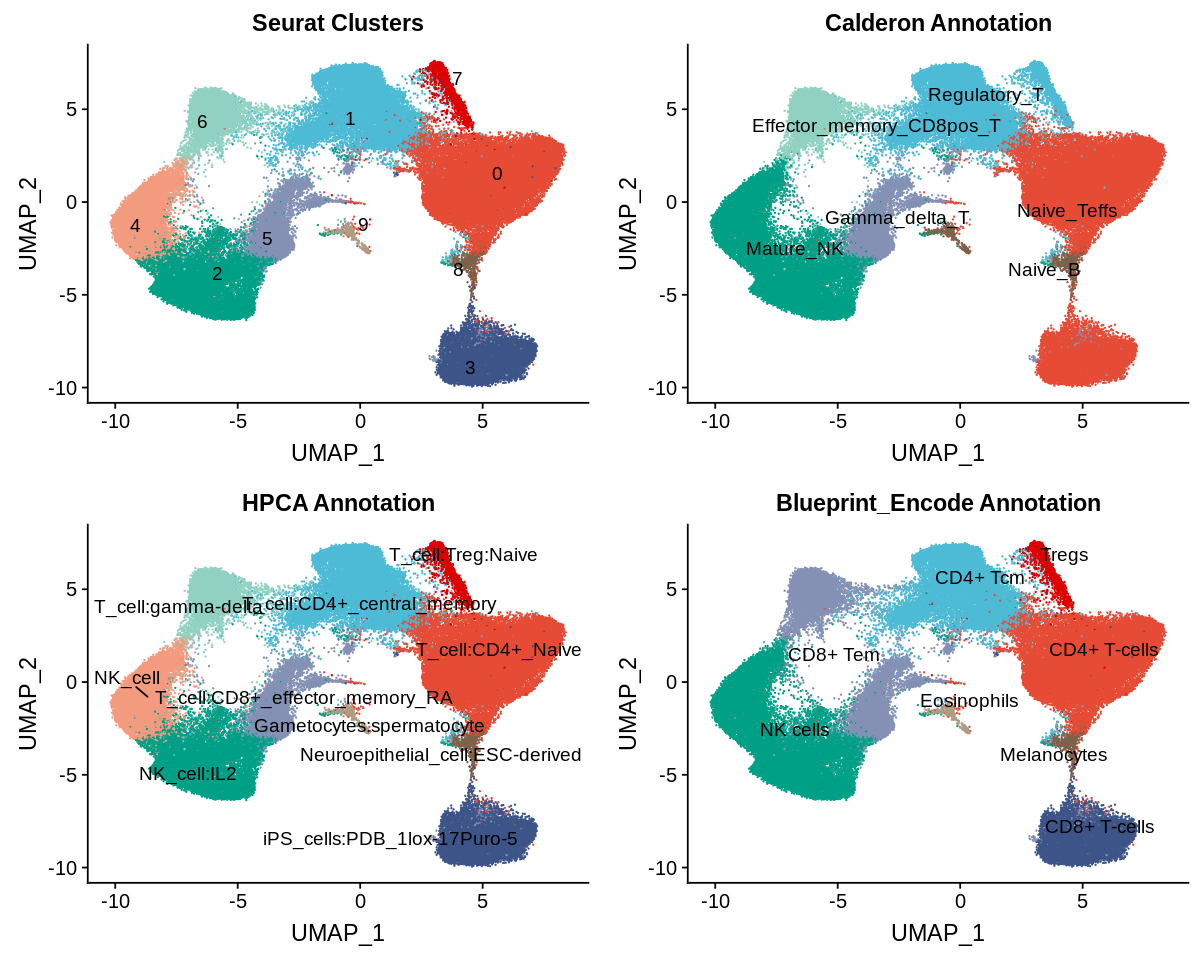

In [169]:
# compare annotations from different reference bulk datasets
options(repr.plot.width=10, repr.plot.height=8)

plot_grid(umapplot_seurat_clusters, umapplots[[3]],
          umapplots[[1]], umapplots[[2]], nrow=2)

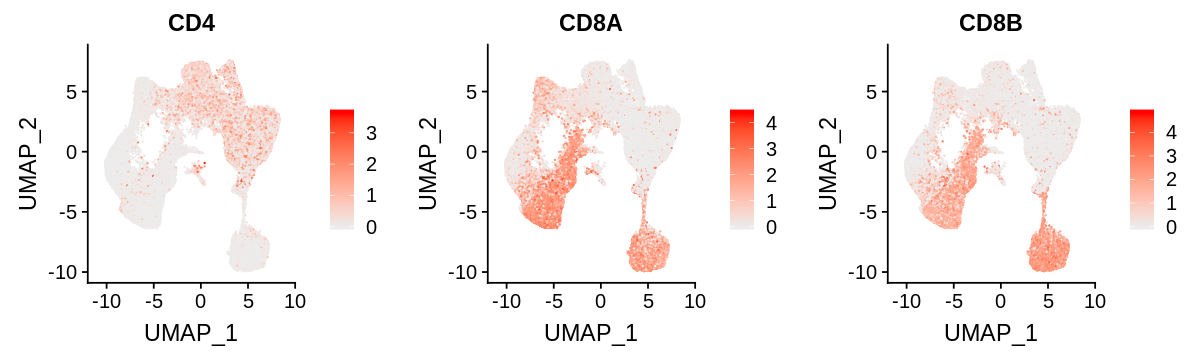

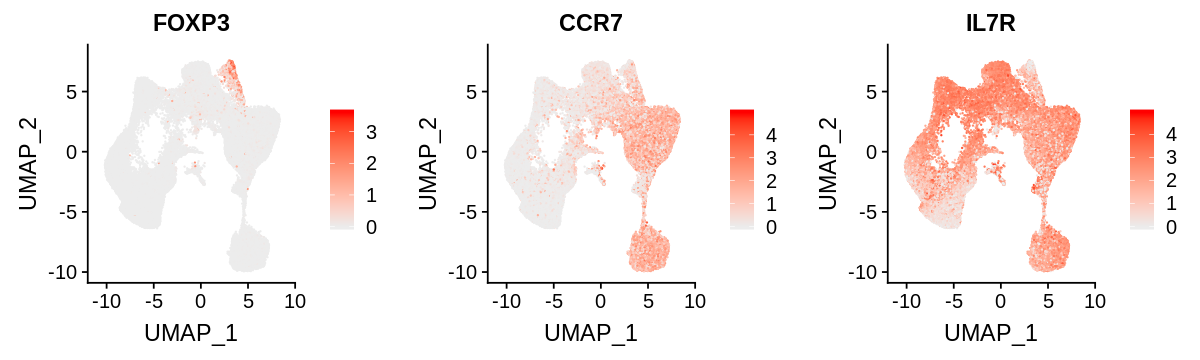

In [45]:
options(repr.plot.width=10, repr.plot.height=3)

FeaturePlot(merged.integrated, features = c("CD4", "CD8A", "CD8B"), ncol=3,
            min.cutoff = c(0,0,0), max.cutoff=c(5,5,5), cols= c('#ececec', 'red'))

FeaturePlot(merged.integrated, features = c("FOXP3", "CCR7", "IL7R"), ncol=3,
            min.cutoff = c(0,0,0), max.cutoff=c(5,5,5), cols= c('#ececec', 'red'))

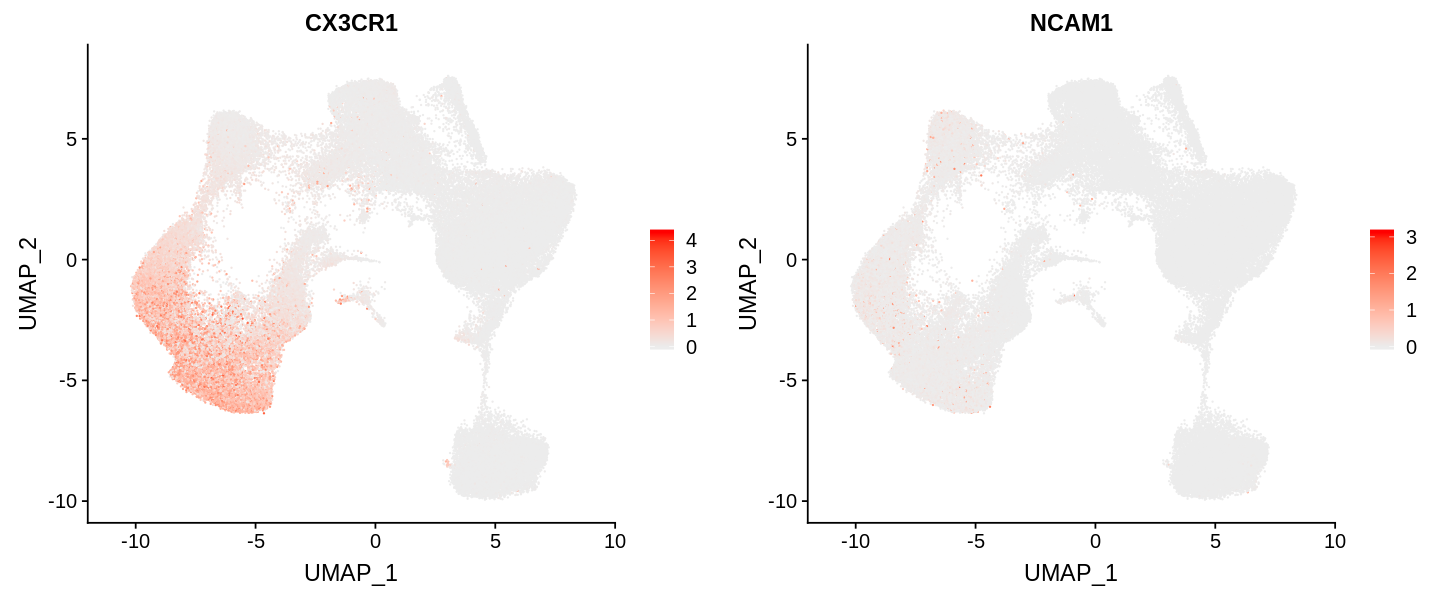

In [88]:
# NCAM1 = CD56 (NKT marker)
FeaturePlot(merged.integrated, features = c("CX3CR1", "NCAM1"), ncol=2,
            min.cutoff = c(0,0), cols= c('#ececec', 'red'))

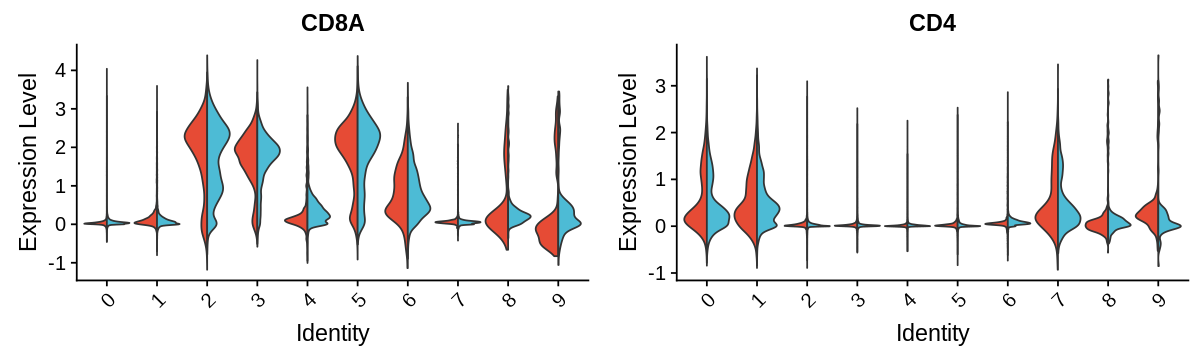

In [178]:
options(repr.plot.width=10, repr.plot.height=3)

VlnPlot(merged.integrated, c("CD8A","CD4"), group.by="seurat_clusters", 
        split.by = 'group', pt.size=0, cols=mypal)

## define clusters using seurat 

In [38]:
# find genes that define cell clusters
tcell.markers <- FindAllMarkers(merged.integrated, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8
Calculating cluster 9


In [42]:
tcell.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_logFC)

p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0.000000e+00,0.8622823,0.970,0.797,0.000000e+00,0,CCR7
0.000000e+00,0.7386380,0.936,0.770,0.000000e+00,0,LEF1
0.000000e+00,0.6895128,0.891,0.702,0.000000e+00,0,MAL
0.000000e+00,0.6639202,0.994,0.919,0.000000e+00,0,LTB
0.000000e+00,0.6212076,0.928,0.842,0.000000e+00,0,TCF7
0.000000e+00,0.7126419,0.928,0.849,0.000000e+00,1,ITGB1
0.000000e+00,0.6361422,0.985,0.966,0.000000e+00,1,S100A11
0.000000e+00,0.6159799,0.972,0.939,0.000000e+00,1,CRIP1
0.000000e+00,0.6155434,0.917,0.849,0.000000e+00,1,CD82


In [39]:
save(tcell.markers, file="r_objects/tcell.markers.RData")

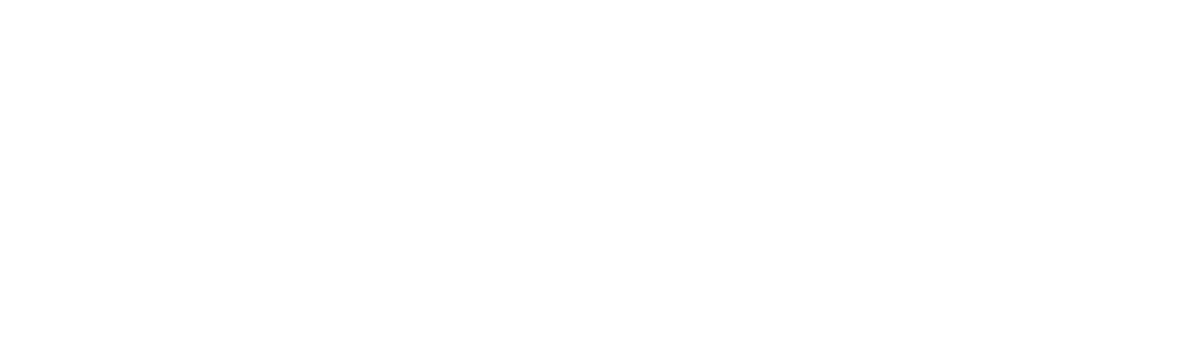

In [179]:
top5 <- tcell.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_logFC)

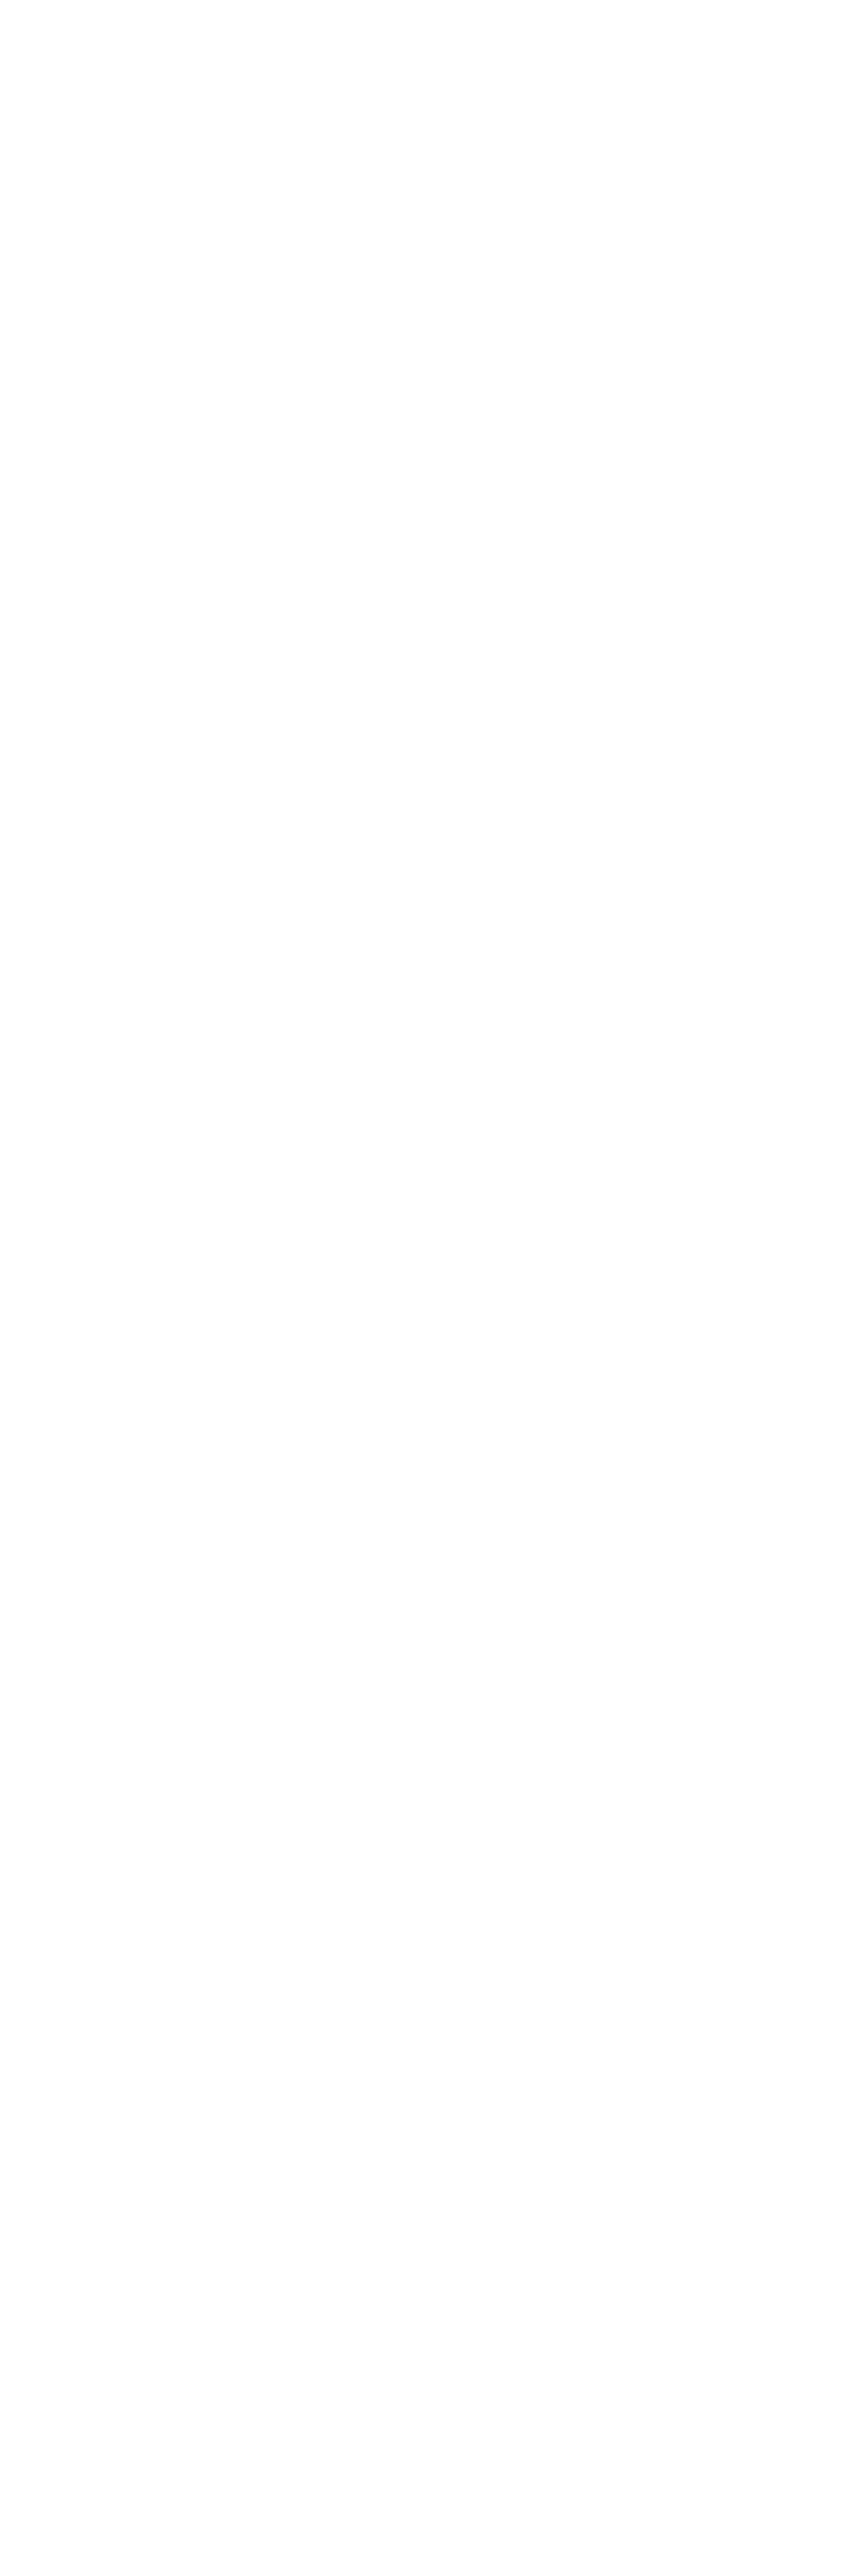

In [180]:
options(repr.plot.width=10, repr.plot.height=30)

DoHeatmap(merged.integrated, features = top5$gene) + NoLegend()

In [91]:
?VlnPlot

In [ ]:
# CD4+ T cell clusters
p1 <- FeaturePlot(merged.integrated, features = c("FOXP3", "IL2RA", "CTLA4")) # Treg = cluster0
p2 <- FeaturePlot(merged.integrated, features = c("BTLA", "CD200")) # Tfh
p3 <- FeaturePlot(merged.integrated, features = c("IL26", "KLRB1")) # Th17

CombinePlots(list(p1,p2,p3), nrow=1, legend = 'bottom')

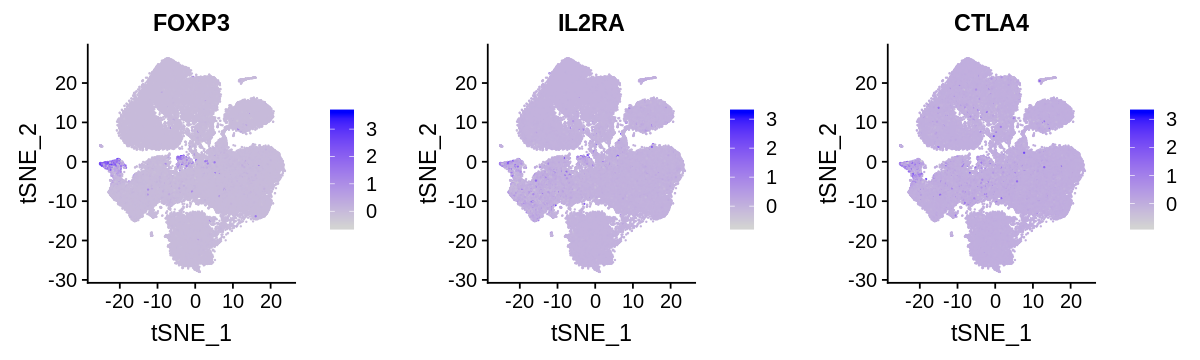

In [88]:
options(repr.plot.width=10, repr.plot.height=3)

FeaturePlot(merged.integrated, features = c("FOXP3", "IL2RA", "CTLA4"), ncol=3) # Treg = cluster0

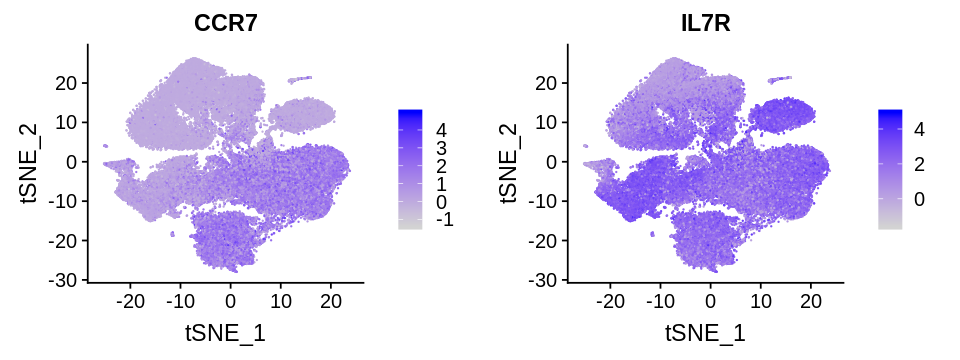

In [89]:
options(repr.plot.width=8, repr.plot.height=3)

FeaturePlot(merged.integrated, features = c("CCR7", "IL7R")) # naive = cluster2

In [109]:
?FeaturePlot

In [ ]:
head(merged.integrated@meta.data)

# single-sample analysis

In [ ]:
data <- Read10X(data.dir = "HC15-WTA/outs/filtered_feature_bc_matrix/")

# Initialize the Seurat object with the raw (non-normalized data)
seurat_obj <- CreateSeuratObject(counts = data, project = "HC15", min.cells = 3, min.features = 200)
# seurat_obj$sample <- dirname
seurat_obj[["percent.mt"]] <- PercentageFeatureSet(seurat_obj, pattern = "^MT-")

seurat_obj <- subset(seurat_obj, subset = nFeature_RNA > 200 & percent.mt < 10)
seurat_obj <- NormalizeData(seurat_obj, verbose = FALSE)
seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)

In [ ]:
tail(seurat_obj@meta.data)

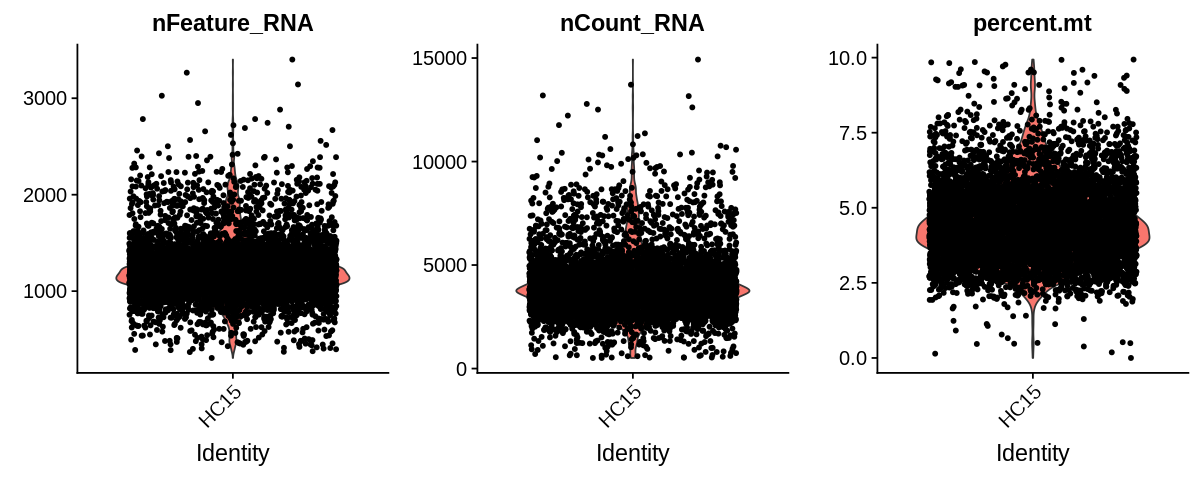

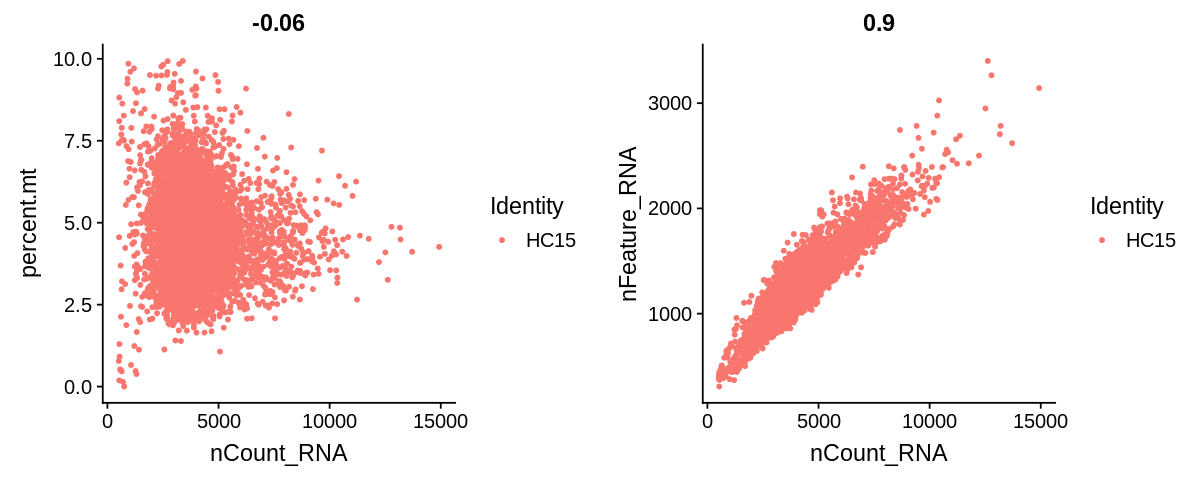

In [83]:
options(repr.plot.width=10, repr.plot.height=4)

VlnPlot(seurat_obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), 
        group.by="orig.ident", ncol = 3)

plot1 <- FeatureScatter(seurat_obj, feature1 = "nCount_RNA", feature2 = "percent.mt", group.by="orig.ident")
plot2 <- FeatureScatter(seurat_obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA", group.by="orig.ident")
CombinePlots(plots = list(plot1, plot2))

When using repel, set xnudge and ynudge to 0 for optimal results


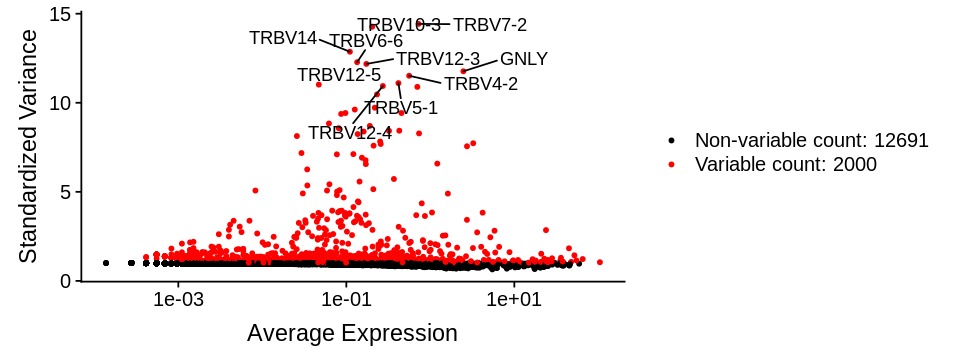

In [96]:
# variable genes
# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(seurat_obj), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(seurat_obj)
LabelPoints(plot = plot1, points = top10, repel = TRUE)

In [ ]:
# TR gene percent
seurat_obj[["percent.tr"]] <- PercentageFeatureSet(seurat_obj, pattern = "^TRB")

head(seurat_obj@meta.data)

In [ ]:
# scale
# seurat_obj <- ScaleData(seurat_obj, features = rownames(seurat_obj))
seurat_obj <- ScaleData(seurat_obj, vars.to.regress = c("S.Score", "G2M.Score"), features = rownames(seurat_obj))


# pca
seurat_obj <- RunPCA(seurat_obj, features = VariableFeatures(object = seurat_obj))
print(seurat_obj[["pca"]], dims = 1:5, nfeatures = 5)
VizDimLoadings(seurat_obj, dims = 1:2, reduction = "pca")
p1 <- DimPlot(seurat_obj, reduction = "pca", group.by = "orig.ident")
p1
# CombinePlots(list(p1,p2,p3), nrow=1)

DimHeatmap(seurat_obj, dims = 1, cells = 500, balanced = TRUE)


In [ ]:
# cluster
seurat_obj <- FindNeighbors(seurat_obj, dims = 1:20, k.param = 30)
seurat_obj <- FindClusters(seurat_obj, resolution = 0.4)
head(Idents(seurat_obj), 5)

In [16]:
library(reticulate)
use_python("/storage/joypai/.linuxbrew/bin/python3")
use_condaenv(condaenv="Renv", conda="/storage/joypai/software/miniconda3/bin/conda")
reticulate::py_config()

python:         /storage/joypai/.linuxbrew/bin/python
libpython:      /storage/joypai/.linuxbrew/Cellar/python@2/2.7.16/lib/libpython2.7.so
pythonhome:     /storage/joypai/.linuxbrew/Cellar/python@2/2.7.16:/storage/joypai/.linuxbrew/Cellar/python@2/2.7.16
version:        2.7.16 (default, May 15 2019, 16:51:02)  [GCC 5.5.0]
numpy:          /storage/joypai/.linuxbrew/Cellar/python@2/2.7.16/lib/python2.7/site-packages/numpy
numpy_version:  1.16.4
umap:           [NOT FOUND]

python versions found: 
 /storage/joypai/.linuxbrew/bin/python
 /usr/bin/python

python:         /storage/joypai/.linuxbrew/bin/python3
libpython:      /storage/joypai/.linuxbrew/Cellar/python/3.7.3/lib/libpython3.7m.so
pythonhome:     /storage/joypai/.linuxbrew/Cellar/python/3.7.3:/storage/joypai/.linuxbrew/Cellar/python/3.7.3
version:        3.7.3 (default, May 16 2019, 10:07:48)  [GCC 5.5.0]
numpy:          /storage/joypai/.linuxbrew/Cellar/python/3.7.3/lib/python3.7/site-packages/numpy
numpy_version:  1.16.4

python versions found: 
 /storage/joypai/.linuxbrew/bin/python3
 /storage/joypai/.linuxbrew/bin/python
 /usr/bin/python

In [4]:
seurat_obj <- RunUMAP(seurat_obj, dims = 1:20, n.neighbors = 40, min.dist = 0.001)
# seurat_obj <- RunTSNE(object = seurat_obj, reduction = "pca", dims = 1:50)

ERROR: Error in RunUMAP(seurat_obj, dims = 1:20, n.neighbors = 40, min.dist = 0.001): object 'seurat_obj' not found


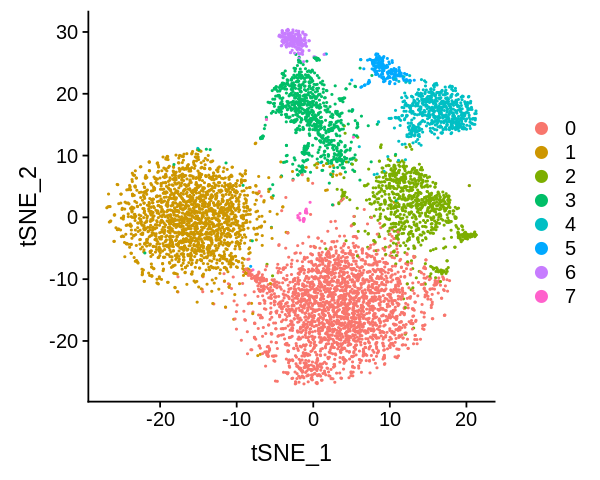

In [80]:
options(repr.plot.width=5, repr.plot.height=4)

cluster_plot <- DimPlot(seurat_obj, reduction = "tsne", group.by="seurat_clusters")
cluster_plot
# tp_plot <- DimPlot(seurat_obj, reduction = "umap", group.by="timepoint")
# patient_plot <- DimPlot(seurat_obj, reduction = "umap", group.by="patient_id")
# CombinePlots(list(cluster_plot, tp_plot, patient_plot), nrow=1, legend = 'bottom')

# DimPlot(seurat_obj, reduction = "umap", group.by="seurat_clusters", split.by = "timepoint")

In [ ]:
# find genes that define cell clusters
cluster.markers <- FindAllMarkers(seurat_obj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

In [79]:
cluster.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_logFC)

p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
6.902600e-142,0.5145587,0.626,0.357,1.014061e-137,0,MAL
3.712787e-138,0.4990195,0.621,0.349,5.454455e-134,0,CCR7
0.000000e+00,1.5936854,0.649,0.048,0.000000e+00,1,LINC02446
0.000000e+00,1.3578998,0.958,0.226,0.000000e+00,1,CD8B
0.000000e+00,0.9944833,0.589,0.096,0.000000e+00,2,ITGB1
3.202988e-187,0.9312342,0.894,0.554,4.705509e-183,2,CRIP1
0.000000e+00,2.0434998,0.963,0.218,0.000000e+00,3,CCL5
0.000000e+00,1.6211172,0.889,0.192,0.000000e+00,3,NKG7
0.000000e+00,2.4022270,0.985,0.132,0.000000e+00,4,KLRB1


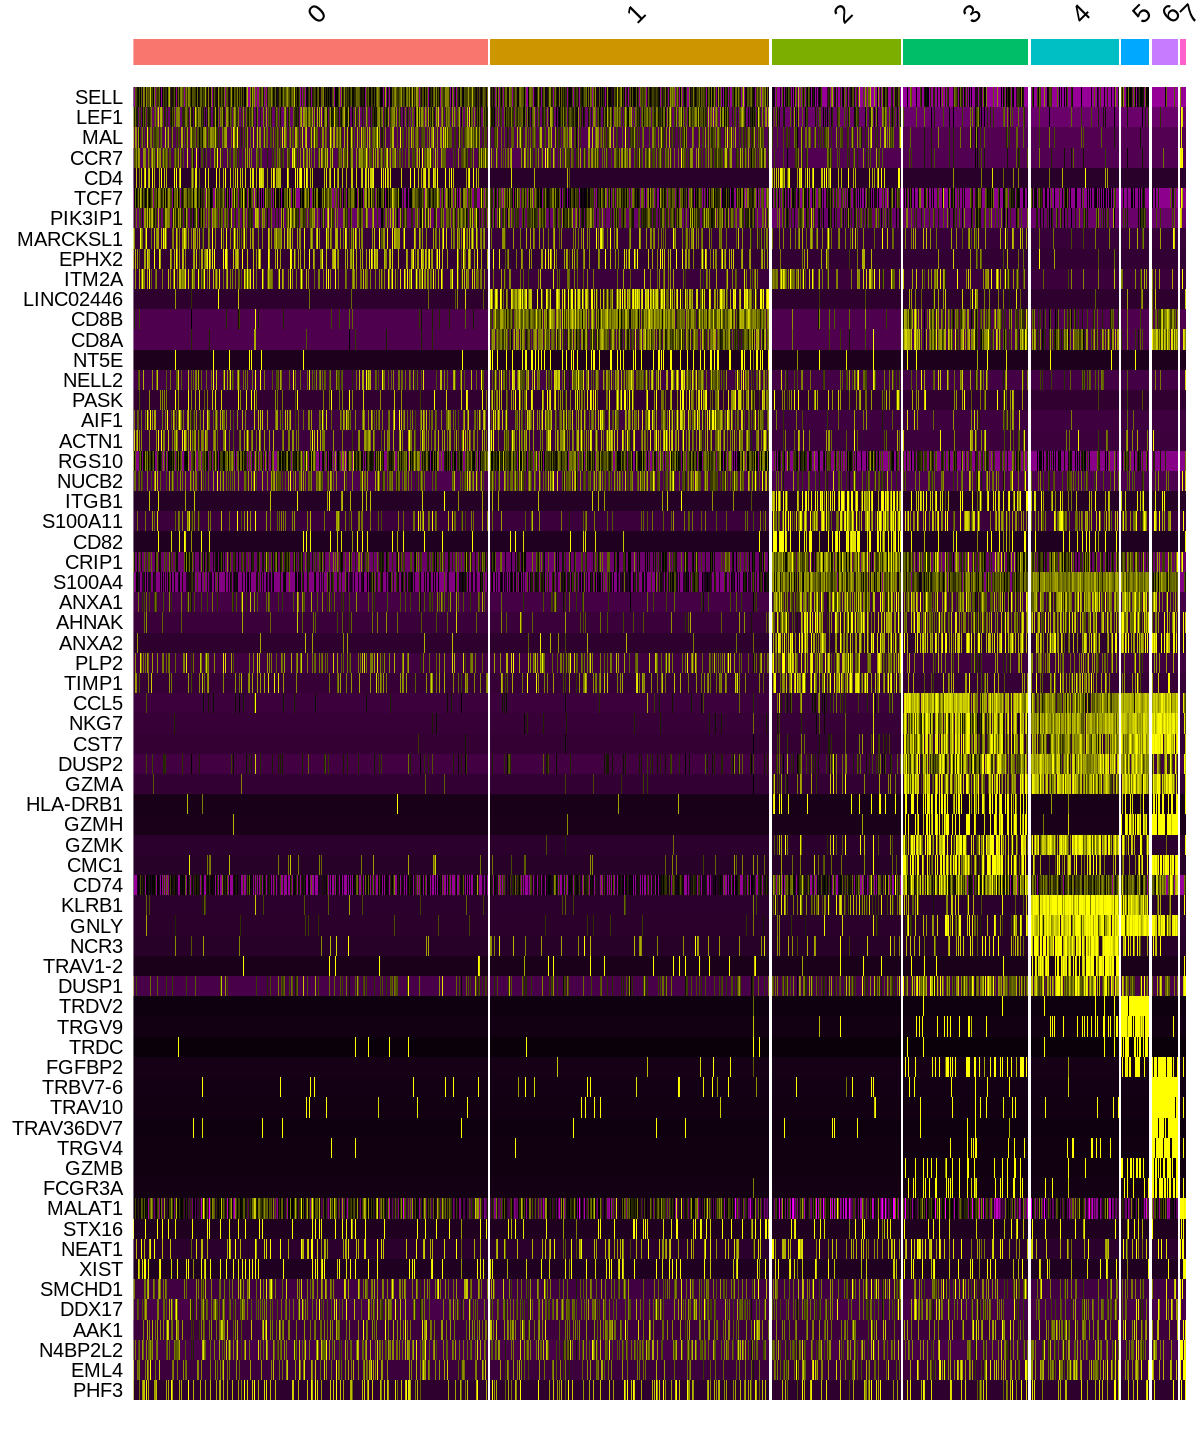

In [78]:
options(repr.plot.width=10, repr.plot.height=12)

top10 <- cluster.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
DoHeatmap(seurat_obj, features = top10$gene) + NoLegend()
